In [9]:
import os
import time
import yaml
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import Dataset, DataLoader

import brevitas.nn as qnn
from brevitas.quant import Int8WeightPerTensorFixedPoint
from brevitas.quant import Int8ActPerTensorFixedPoint

# ==========================
# CONFIG
# ==========================
DATASET_PATH = "coco_mini/coco_min"
IMG_SIZE = 224
NUM_CLASSES = 10
NUM_ANCHORS = 3
BATCH_SIZE = 8
EPOCHS = 50
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", DEVICE)

Device: cuda


In [15]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset

class YOLODataset(Dataset):
    def __init__(self, root_dir, split="train", img_size=224):
        self.img_size = img_size
        self.images_dir = os.path.join(root_dir, split, "images")
        self.labels_dir = os.path.join(root_dir, split, "labels")

        self.image_files = [
            f for f in sorted(os.listdir(self.images_dir))
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

        print(f"{split.upper()} DATASET LOADED")
        print(f"Images found: {len(self.image_files)}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))
        img_tensor = torch.tensor(img, dtype=torch.float32)

        label_path = os.path.join(
            self.labels_dir,
            os.path.splitext(img_name)[0] + ".txt"
        )

        boxes = []

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()

                    if len(parts) < 7:
                        continue  # need at least 3 points

                    cls = float(parts[0])
                    coords = list(map(float, parts[1:]))

                    xs = coords[0::2]
                    ys = coords[1::2]

                    xmin = min(xs)
                    xmax = max(xs)
                    ymin = min(ys)
                    ymax = max(ys)

                    # Convert to YOLO format
                    x_center = (xmin + xmax) / 2
                    y_center = (ymin + ymax) / 2
                    width = xmax - xmin
                    height = ymax - ymin

                    boxes.append([cls, x_center, y_center, width, height])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 5), dtype=torch.float32)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)

        return img_tensor, boxes


def collate_fn(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs, 0)
    return imgs, targets

In [4]:
class QuantConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, s):
        super().__init__()
        self.conv = qnn.QuantConv2d(
            in_ch,
            out_ch,
            kernel_size=k,
            stride=s,
            padding=k // 2,
            bias=False,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = qnn.QuantReLU(
            bit_width=8,
            act_quant=Int8ActPerTensorFixedPoint,
            return_quant_tensor=False
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class TinyFINNDetector(nn.Module):
    def __init__(self, nc=10, anchors=3):
        super().__init__()
        self.out_ch = anchors * (5 + nc)

        self.backbone = nn.Sequential(
            QuantConvBlock(3, 32, 3, 1),
            QuantConvBlock(32, 64, 3, 2),
            QuantConvBlock(64, 128, 3, 2),
            QuantConvBlock(128, 256, 3, 2),
            QuantConvBlock(256, 256, 3, 2),
            QuantConvBlock(256, 256, 3, 1),
        )

        self.head = qnn.QuantConv2d(
            256,
            self.out_ch,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True,
            weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x


model = TinyFINNDetector(NUM_CLASSES, NUM_ANCHORS).to(DEVICE)
print(model)

TinyFINNDetector(
  (backbone): Sequential(
    (0): QuantConvBlock(
      (conv): QuantConv2d(
        3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (input_quant): ActQuantProxyFromInjector(
          (_zero_hw_sentinel): StatelessBuffer()
        )
        (output_quant): ActQuantProxyFromInjector(
          (_zero_hw_sentinel): StatelessBuffer()
        )
        (weight_quant): WeightQuantProxyFromInjector(
          (_zero_hw_sentinel): StatelessBuffer()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClampSte()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
              (input_view_impl): Identity()
            )
            (scaling_impl): StatsFromParameterScaling(
              (parameter_list_stats): _ParameterListStats(
                (first_tracked_param): _ViewParameter

In [5]:
def yolo_loss(pred):
    B, C, H, W = pred.shape
    pred = pred.view(B, NUM_ANCHORS, 5 + NUM_CLASSES, H, W)

    obj_pred = pred[:, :, 4]
    cls_pred = pred[:, :, 5:]
    box_pred = pred[:, :, 0:4]

    loss_obj = obj_pred.mean()
    loss_cls = cls_pred.mean()
    loss_box = box_pred.mean()

    return loss_obj + loss_cls + loss_box

Device: cuda
Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
TRAIN DATASET LOADED
Images found: 12000
VALID DATASET LOADED
Images found: 2000

===== Epoch 1/10 =====
Batch 0/1500  Loss: 1.5745
Batch 100/1500  Loss: 0.0349
Batch 200/1500  Loss: 0.0216
Batch 300/1500  Loss: 0.0261
Batch 400/1500  Loss: 0.0160
Batch 500/1500  Loss: 0.0234
Batch 600/1500  Loss: 0.0204
Batch 700/1500  Loss: 0.0301
Batch 800/1500  Loss: 0.0189
Batch 900/1500  Loss: 0.0066
Batch 1000/1500  Loss: 0.0055
Batch 1100/1500  Loss: 0.0173
Batch 1200/1500  Loss: 0.0125
Batch 1300/1500  Loss: 0.0064
Batch 1400/1500  Loss: 0.0063
Epoch Loss: 0.030752704083298645
Epoch Time: 113.95548748970032


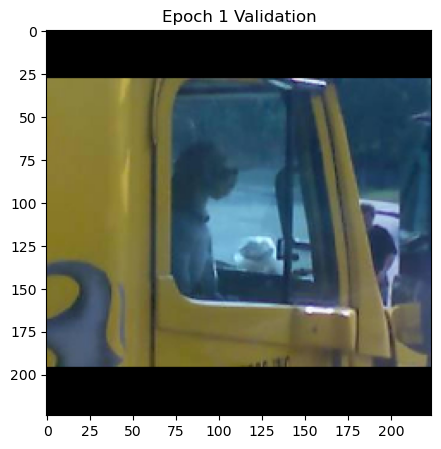

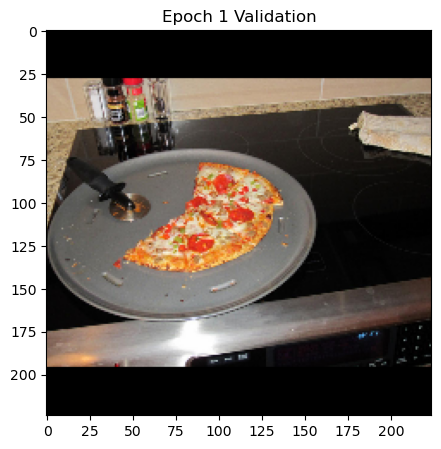


===== Epoch 2/10 =====
Batch 0/1500  Loss: 0.0196
Batch 100/1500  Loss: 0.0104
Batch 200/1500  Loss: 0.0156
Batch 300/1500  Loss: 0.0170
Batch 400/1500  Loss: 0.0092
Batch 500/1500  Loss: 0.0167
Batch 600/1500  Loss: 0.0086
Batch 700/1500  Loss: 0.0259
Batch 800/1500  Loss: 0.0309
Batch 900/1500  Loss: 0.0104
Batch 1000/1500  Loss: 0.0119
Batch 1100/1500  Loss: 0.0169
Batch 1200/1500  Loss: 0.0252
Batch 1300/1500  Loss: 0.0122
Batch 1400/1500  Loss: 0.0187
Epoch Loss: 0.015524889416216563
Epoch Time: 91.76041436195374


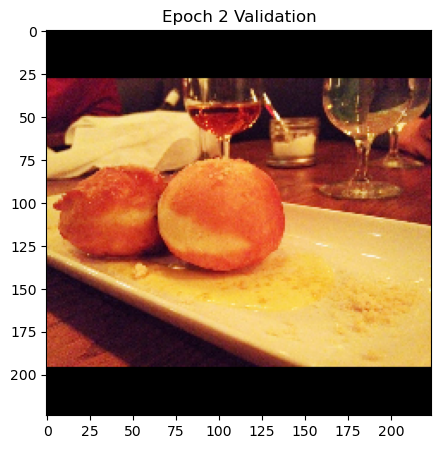

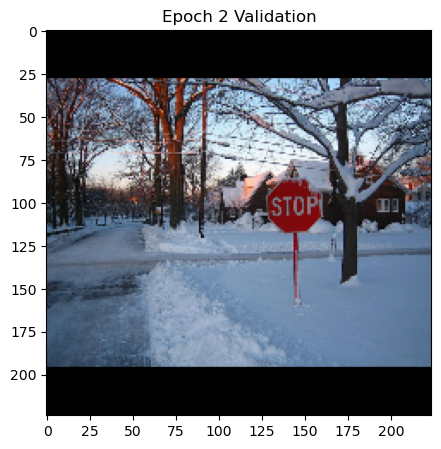


===== Epoch 3/10 =====
Batch 0/1500  Loss: 0.0111
Batch 100/1500  Loss: 0.0112
Batch 200/1500  Loss: 0.0120
Batch 300/1500  Loss: 0.0106
Batch 400/1500  Loss: 0.0280
Batch 500/1500  Loss: 0.0163
Batch 600/1500  Loss: 0.0105
Batch 700/1500  Loss: 0.0160
Batch 800/1500  Loss: 0.0112
Batch 900/1500  Loss: 0.0118
Batch 1000/1500  Loss: 0.0101
Batch 1100/1500  Loss: 0.0131
Batch 1200/1500  Loss: 0.0098
Batch 1300/1500  Loss: 0.0044
Batch 1400/1500  Loss: 0.0099
Epoch Loss: 0.015181670871951308
Epoch Time: 93.52043414115906


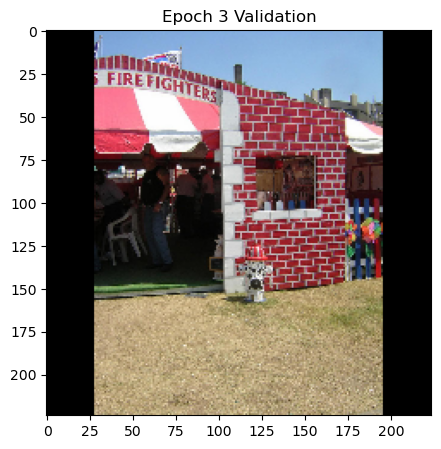

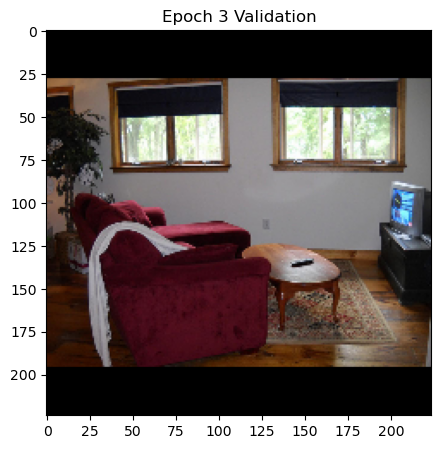


===== Epoch 4/10 =====
Batch 0/1500  Loss: 0.0074
Batch 100/1500  Loss: 0.0269
Batch 200/1500  Loss: 0.0186
Batch 300/1500  Loss: 0.0284
Batch 400/1500  Loss: 0.0173
Batch 500/1500  Loss: 0.0164
Batch 600/1500  Loss: 0.0184
Batch 700/1500  Loss: 0.0073
Batch 800/1500  Loss: 0.0063
Batch 900/1500  Loss: 0.0098
Batch 1000/1500  Loss: 0.0042
Batch 1100/1500  Loss: 0.0147
Batch 1200/1500  Loss: 0.0159
Batch 1300/1500  Loss: 0.0075
Batch 1400/1500  Loss: 0.0186
Epoch Loss: 0.014960948372725397
Epoch Time: 96.69480800628662


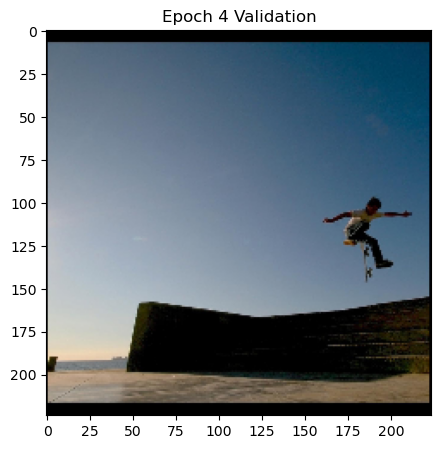

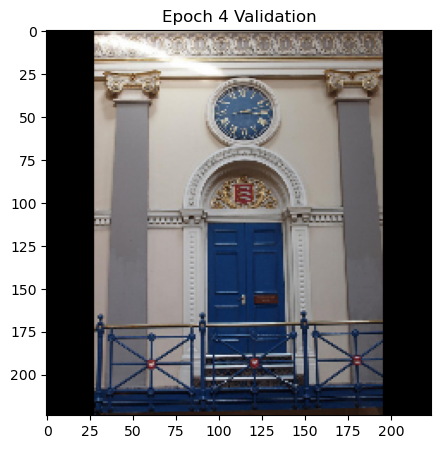


===== Epoch 5/10 =====
Batch 0/1500  Loss: 0.0210
Batch 100/1500  Loss: 0.0187
Batch 200/1500  Loss: 0.0135
Batch 300/1500  Loss: 0.0106
Batch 400/1500  Loss: 0.0175
Batch 500/1500  Loss: 0.0122
Batch 600/1500  Loss: 0.0051
Batch 700/1500  Loss: 0.0109
Batch 800/1500  Loss: 0.0037
Batch 900/1500  Loss: 0.0059
Batch 1000/1500  Loss: 0.0163
Batch 1100/1500  Loss: 0.0134
Batch 1200/1500  Loss: 0.0088
Batch 1300/1500  Loss: 0.0092
Batch 1400/1500  Loss: 0.0076
Epoch Loss: 0.014740293633037558
Epoch Time: 95.56835794448853


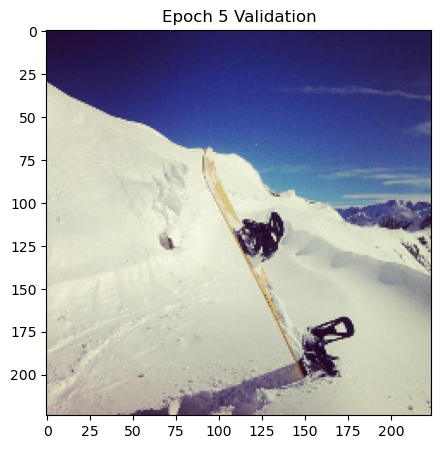

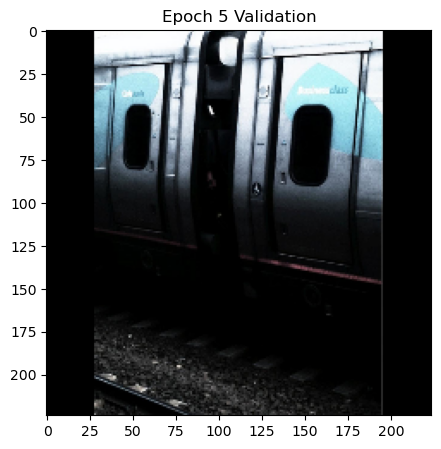


===== Epoch 6/10 =====
Batch 0/1500  Loss: 0.0084
Batch 100/1500  Loss: 0.0146
Batch 200/1500  Loss: 0.0045
Batch 300/1500  Loss: 0.0116
Batch 400/1500  Loss: 0.0165
Batch 500/1500  Loss: 0.0061
Batch 600/1500  Loss: 0.0046
Batch 700/1500  Loss: 0.0169
Batch 800/1500  Loss: 0.0155
Batch 900/1500  Loss: 0.0164
Batch 1000/1500  Loss: 0.0110
Batch 1100/1500  Loss: 0.0142
Batch 1200/1500  Loss: 0.0077
Batch 1300/1500  Loss: 0.0135
Batch 1400/1500  Loss: 0.0096
Epoch Loss: 0.014521118523553013
Epoch Time: 95.79999947547913


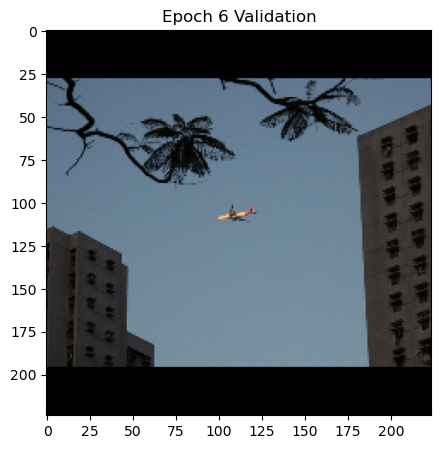

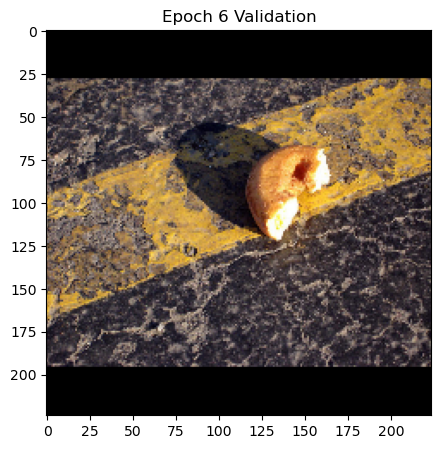


===== Epoch 7/10 =====
Batch 0/1500  Loss: 0.0171
Batch 100/1500  Loss: 0.0038
Batch 200/1500  Loss: 0.0223
Batch 300/1500  Loss: 0.0181
Batch 400/1500  Loss: 0.0123
Batch 500/1500  Loss: 0.0182
Batch 600/1500  Loss: 0.0198
Batch 700/1500  Loss: 0.0061
Batch 800/1500  Loss: 0.0146
Batch 900/1500  Loss: 0.0155
Batch 1000/1500  Loss: 0.0193
Batch 1100/1500  Loss: 0.0275
Batch 1200/1500  Loss: 0.0124
Batch 1300/1500  Loss: 0.0166
Batch 1400/1500  Loss: 0.0146
Epoch Loss: 0.014368400822083155
Epoch Time: 92.95055365562439


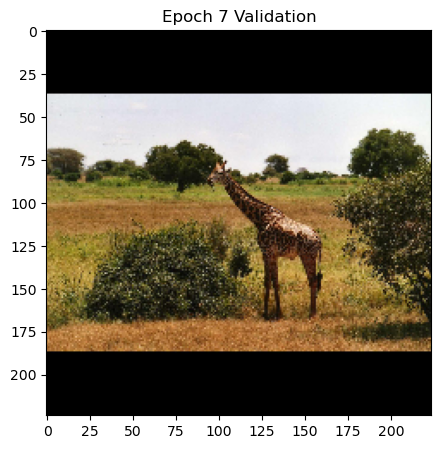

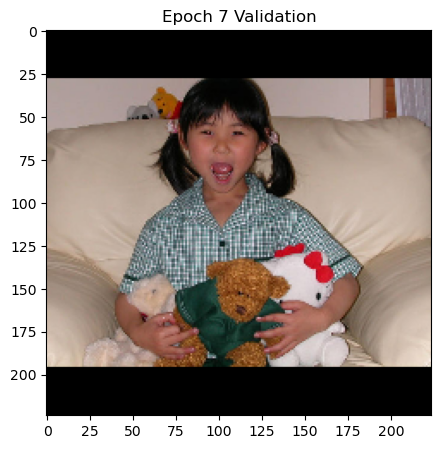


===== Epoch 8/10 =====
Batch 0/1500  Loss: 0.0104
Batch 100/1500  Loss: 0.0107
Batch 200/1500  Loss: 0.0190
Batch 300/1500  Loss: 0.0147
Batch 400/1500  Loss: 0.0134
Batch 500/1500  Loss: 0.0149
Batch 600/1500  Loss: 0.0141
Batch 700/1500  Loss: 0.0130
Batch 800/1500  Loss: 0.0276
Batch 900/1500  Loss: 0.0181
Batch 1000/1500  Loss: 0.0157
Batch 1100/1500  Loss: 0.0075
Batch 1200/1500  Loss: 0.0104
Batch 1300/1500  Loss: 0.0188
Batch 1400/1500  Loss: 0.0032
Epoch Loss: 0.014095856106374413
Epoch Time: 83.17546892166138


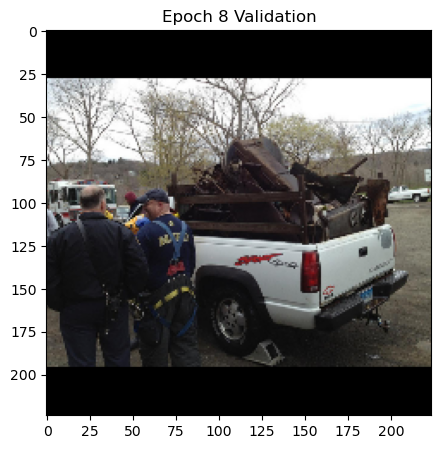

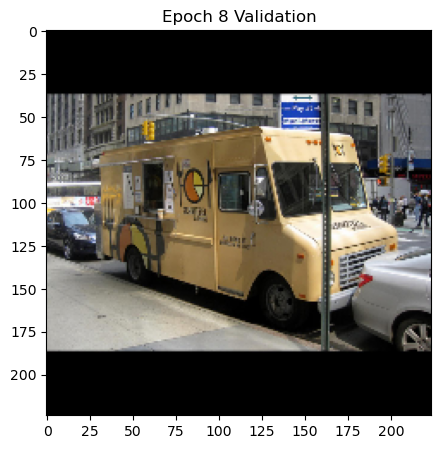


===== Epoch 9/10 =====
Batch 0/1500  Loss: 0.0077
Batch 100/1500  Loss: 0.0196
Batch 200/1500  Loss: 0.0109
Batch 300/1500  Loss: 0.0103
Batch 400/1500  Loss: 0.0131
Batch 500/1500  Loss: 0.0031
Batch 600/1500  Loss: 0.0085
Batch 700/1500  Loss: 0.0104
Batch 800/1500  Loss: 0.0111
Batch 900/1500  Loss: 0.0153
Batch 1000/1500  Loss: 0.0034
Batch 1100/1500  Loss: 0.0188
Batch 1200/1500  Loss: 0.0154
Batch 1300/1500  Loss: 0.0124
Batch 1400/1500  Loss: 0.0283
Epoch Loss: 0.013840090557467193
Epoch Time: 85.052255153656


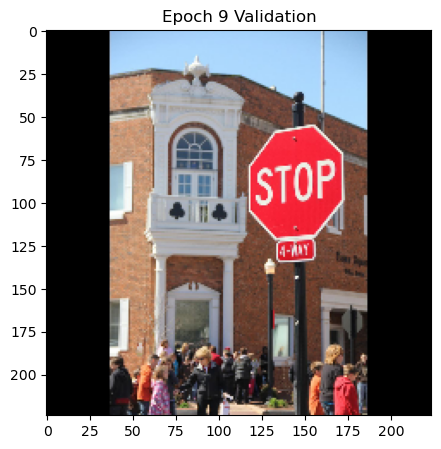

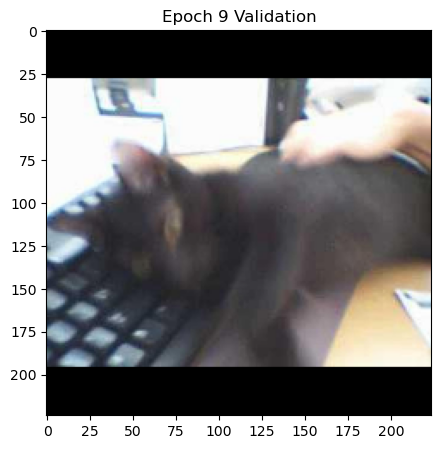


===== Epoch 10/10 =====
Batch 0/1500  Loss: 0.0152
Batch 100/1500  Loss: 0.0063
Batch 200/1500  Loss: 0.0108
Batch 300/1500  Loss: 0.0179
Batch 400/1500  Loss: 0.0188
Batch 500/1500  Loss: 0.0214
Batch 600/1500  Loss: 0.0211
Batch 700/1500  Loss: 0.0105
Batch 800/1500  Loss: 0.0065
Batch 900/1500  Loss: 0.0216
Batch 1000/1500  Loss: 0.0157
Batch 1100/1500  Loss: 0.0079
Batch 1200/1500  Loss: 0.0208
Batch 1300/1500  Loss: 0.0044
Batch 1400/1500  Loss: 0.0118
Epoch Loss: 0.013491344968167444
Epoch Time: 83.71595883369446


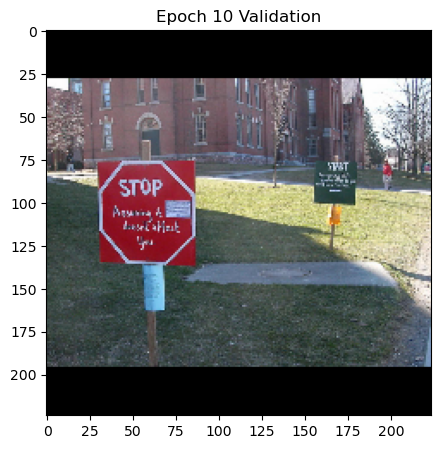

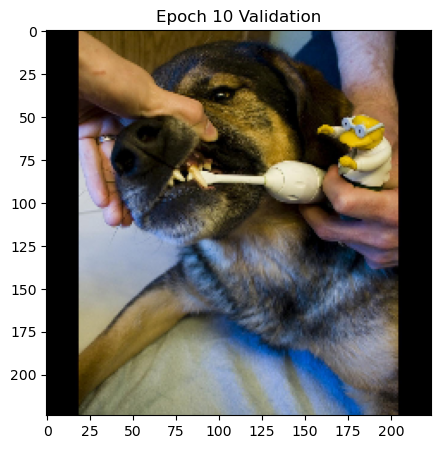

Model Saved.


In [19]:
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ================================
# SETTINGS
# ================================
IMG_SIZE = 224
NUM_CLASSES = 20
NUM_ANCHORS = 3
BATCH_SIZE = 8
EPOCHS = 10
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", DEVICE)

# ================================
# SELECT FIRST 20 CLASSES
# ================================
labels_dir = os.path.join(DATASET_PATH, "train", "labels")
all_classes = set()

for file in os.listdir(labels_dir):
    if file.endswith(".txt"):
        with open(os.path.join(labels_dir, file), "r") as f:
            for line in f.readlines():
                cls = int(float(line.strip().split()[0]))
                all_classes.add(cls)

selected_classes = sorted(all_classes)[:20]
class_mapping = {cls: i for i, cls in enumerate(selected_classes)}

print("Training on classes:", selected_classes)

# ================================
# DATASETS
# ================================
train_dataset = YOLODataset(DATASET_PATH, split="train", img_size=IMG_SIZE)
val_dataset = YOLODataset(DATASET_PATH, split="valid", img_size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_fn)

val_loader = DataLoader(val_dataset, batch_size=4,
                        shuffle=True, collate_fn=collate_fn)

# ================================
# MODEL
# ================================
model = TinyFINNDetector(NUM_CLASSES, NUM_ANCHORS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
bce = nn.BCEWithLogitsLoss()
mse = nn.MSELoss()

# ================================
# TRAIN LOOP
# ================================
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    start = time.time()

    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")

    for batch_idx, (imgs, targets) in enumerate(train_loader):
        imgs = imgs.to(DEVICE)
        preds = model(imgs)

        B, C, H, W = preds.shape
        preds = preds.view(B, NUM_ANCHORS, 5 + NUM_CLASSES, H, W)
        target_tensor = torch.zeros_like(preds).to(DEVICE)

        for b in range(B):
            for box in targets[b]:
                orig_cls, x, y, w, h = box
                orig_cls = int(orig_cls.item())

                if orig_cls not in class_mapping:
                    continue

                cls_id = class_mapping[orig_cls]

                gx = min(W - 1, max(0, int(x.item() * W)))
                gy = min(H - 1, max(0, int(y.item() * H)))

                target_tensor[b, 0, 0, gy, gx] = x
                target_tensor[b, 0, 1, gy, gx] = y
                target_tensor[b, 0, 2, gy, gx] = w
                target_tensor[b, 0, 3, gy, gx] = h
                target_tensor[b, 0, 4, gy, gx] = 1.0
                target_tensor[b, 0, 5 + cls_id, gy, gx] = 1.0

        loss_box = mse(preds[:, :, 0:4], target_tensor[:, :, 0:4])
        loss_obj = bce(preds[:, :, 4], target_tensor[:, :, 4])
        loss_cls = bce(preds[:, :, 5:], target_tensor[:, :, 5:])
        loss = loss_box + loss_obj + loss_cls

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)}  Loss: {loss.item():.4f}")

    print("Epoch Loss:", epoch_loss / len(train_loader))
    print("Epoch Time:", time.time() - start)

    # ================================
    # VALIDATION VISUALIZATION
    # ================================
    model.eval()
    with torch.no_grad():
        imgs, targets = next(iter(val_loader))
        imgs = imgs.to(DEVICE)
        preds = model(imgs)

        preds = preds.view(imgs.size(0), NUM_ANCHORS,
                           5 + NUM_CLASSES,
                           preds.shape[2],
                           preds.shape[3])

        for i in range(min(2, imgs.size(0))):
            img = imgs[i].cpu().numpy().transpose(1, 2, 0)
            img = (img * 255).astype("uint8")

            plt.figure(figsize=(5,5))
            plt.imshow(img)

            for a in range(NUM_ANCHORS):
                obj_map = torch.sigmoid(preds[i, a, 4]).cpu()
                ys, xs = torch.where(obj_map > 0.5)

                for y, x in zip(ys, xs):
                    bx = preds[i, a, 0, y, x].item()
                    by = preds[i, a, 1, y, x].item()
                    bw = preds[i, a, 2, y, x].item()
                    bh = preds[i, a, 3, y, x].item()

                    x1 = int((bx - bw/2) * IMG_SIZE)
                    y1 = int((by - bh/2) * IMG_SIZE)
                    w_box = int(bw * IMG_SIZE)
                    h_box = int(bh * IMG_SIZE)

                    rect = plt.Rectangle((x1, y1), w_box, h_box,
                                         fill=False, edgecolor='red', linewidth=2)
                    plt.gca().add_patch(rect)

            plt.title(f"Epoch {epoch+1} Validation")
            plt.show()

torch.save(model.state_dict(), "tiny_finn_detector_20cls.pth")
print("Model Saved.")

In [1]:
!pip install torch torchvision brevitas pyyaml opencv-python

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 42.8 MB/s  0:00:01 eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
